In [44]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import ternary
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from torchsummary import summary

from ensemblecalibration.nn_training.sampling import experiment_binary_nn
from ensemblecalibration.nn_training.model import MLPCalW
from ensemblecalibration.nn_training.dataset import MLPDataset
from ensemblecalibration.nn_training.train import train_mlp
from ensemblecalibration.nn_training.losses import SKCELoss, FocalLoss, LpLoss
from ensemblecalibration.calibration.plot_functions import plot_scatterplot_ternary
from ensemblecalibration.calibration.calibration_estimates.ece_kde import get_ece_kde, get_bandwidth


# Ensemble Model for Binary Classification: 
### MLP training to predict the optimal convex combination

Sample data points for training and validation, as well as probabilitic predictions, and an optimal convex combination which uses a fixed function taking the instance values as arguments. 

The labels are then sampled from the categorical distribution induced by the predicted probabilities of the convex combination.
 

In [42]:
# set parameters

# data parameters
N_SAMPLES_TRAIN = 5000
N_SAMPLES_VAL = 1000
N_ENS = 2
lower_bound_inst = 0
upper_bound_inst = 1
# degree of the function which is used to generate the weights, in dependence of the instances
deg_weights = 1

N_EPOCHS = 300
LR = 0.001
BATCH_SIZE = 1000
BW = 1
# squared kernel calibration error loss
loss_skce = SKCELoss()
# L2 loss
loss_l2 = LpLoss(p=5, bw=1)

optimizer = torch.optim.RMSprop
N_ITER = 10


# generate data for training and validation
# training data
x_train, p_probs, weights, p_bar, y_labels = experiment_binary_nn(N_SAMPLES_TRAIN, N_ENS, x_lower=lower_bound_inst,
                                                                    x_upper=upper_bound_inst, deg=deg_weights)

# validation data
x_val, p_probs_val, weights_val, p_bar_val, y_labels_val = experiment_binary_nn(N_SAMPLES_VAL,
                                                                                 N_ENS, x_lower=lower_bound_inst,
                                                                                    x_upper=upper_bound_inst,
                                                                                    deg=deg_weights)

Visualize the probabilitic predictions of the c.c. vs the actual labels

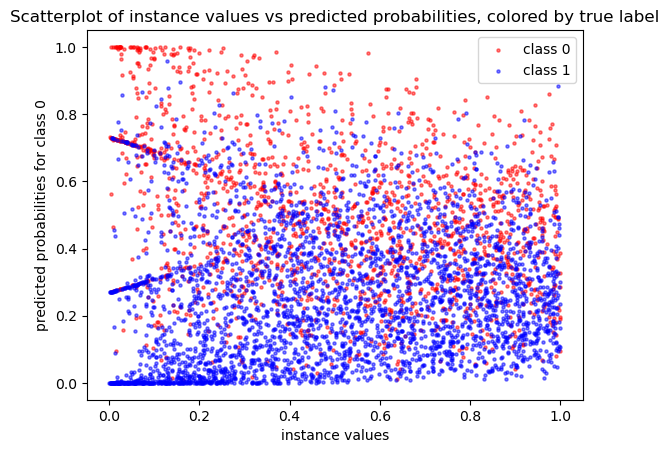

In [31]:
fig, ax = plt.subplots()

# scatterplot of instance values vs predicted probabilities, colored by true label
ax.scatter(
    x_train[y_labels == 0],
    p_bar[:, 0][y_labels == 0],
    c="red",
    label="class 0",
    alpha=0.5,
    s=5,
)
ax.scatter(
    x_train[y_labels == 1],
    p_bar[:, 0][y_labels == 1],
    c="blue",
    label="class 1",
    alpha=0.5,
    s=5,
)
ax.set_xlabel("instance values")
ax.set_ylabel("predicted probabilities for class 0")
ax.set_title(
    "Scatterplot of instance values vs predicted probabilities, colored by true label"
)
plt.legend()


create datasets fro training and validation

In [32]:
dataset_train = MLPDataset(x_train, p_probs, y_labels)
dataset_val = MLPDataset(x_val, p_probs_val, y_labels_val)

In [43]:
# chek "real" loss
loss_real_l2 = loss_l2(
    torch.from_numpy(p_probs).float(),
    torch.from_numpy(weights).float(),
    torch.from_numpy(y_labels),
)
print(f"Real loss using L2: {loss_real_l2}")
loss_real_skce = loss_skce(
    torch.from_numpy(p_probs).float(),
    torch.from_numpy(weights).float(),
    torch.from_numpy(y_labels),
)
print(f"Real loss using SKCE: {loss_real_skce}")


Real loss using L2: nan
Real loss using SKCE: 7.953013803074782e-10


array([0, 1, 0, ..., 1, 1, 1])

In [57]:
# Generate dummy probability scores and labels
f = torch.rand((50, 3))
# normalize
f = f / torch.sum(f, dim=1).unsqueeze(-1)
y = torch.randint(0, 3, (50,))

get_ece_kde(f, y, bandwidth=0.001, p=1, mc_type='canonical', device='cpu')
f

tensor([[0.1468, 0.6383, 0.2150],
        [0.4336, 0.4455, 0.1209],
        [0.3590, 0.4915, 0.1496],
        [0.0228, 0.2325, 0.7447],
        [0.2301, 0.3498, 0.4201],
        [0.7487, 0.1524, 0.0989],
        [0.3946, 0.4547, 0.1507],
        [0.4264, 0.1999, 0.3737],
        [0.0955, 0.1048, 0.7997],
        [0.1982, 0.3624, 0.4394],
        [0.3052, 0.3743, 0.3205],
        [0.3849, 0.3629, 0.2521],
        [0.2161, 0.4060, 0.3779],
        [0.4339, 0.1672, 0.3989],
        [0.3386, 0.5228, 0.1385],
        [0.0414, 0.3069, 0.6517],
        [0.2205, 0.1614, 0.6181],
        [0.2074, 0.7430, 0.0497],
        [0.3858, 0.0522, 0.5620],
        [0.1670, 0.2022, 0.6308],
        [0.0820, 0.4647, 0.4533],
        [0.5967, 0.2150, 0.1883],
        [0.5011, 0.2634, 0.2355],
        [0.0540, 0.1961, 0.7500],
        [0.3658, 0.1781, 0.4561],
        [0.3122, 0.3169, 0.3709],
        [0.0593, 0.4533, 0.4874],
        [0.7550, 0.2059, 0.0391],
        [0.7140, 0.0929, 0.1931],
        [0.249

In [58]:
# train 10 times, save weights
# train model
weights_preds = []
for n in range(N_ITER):
    model = MLPCalW(in_channels=x_train.shape[1], out_channels=N_ENS, hidden_dim=32, hidden_layers=0, 
                    use_relu=False)

    model, loss_train = train_mlp(model, dataset_train=dataset_train, n_epochs=N_EPOCHS, lr=LR,
                                batch_size=BATCH_SIZE, loss=loss, every_n_epoch=10, optim=optimizer)
    
    weights_pred = model(torch.from_numpy(x_train).float()).detach().numpy()
    weights_preds.append(weights_pred)


NameError: name 'loss' is not defined

In [ ]:
loss_train

array([0.03092546, 0.03090355, 0.03089151, 0.03088158, 0.03087325,
       0.03086586, 0.03085948, 0.03085322, 0.03084796, 0.03084244,
       0.03083749, 0.03083308, 0.03082819, 0.03082465, 0.03081956,
       0.03081542, 0.0308117 , 0.03080795, 0.03080397, 0.03080046,
       0.03079693, 0.0307935 , 0.03078982, 0.03078706, 0.03078319,
       0.03078016, 0.03077698, 0.0307739 , 0.03077125, 0.03076797,
       0.03076497, 0.03076202, 0.03075935, 0.03075645, 0.03075365,
       0.03075077, 0.03074832, 0.03074559, 0.03074286, 0.03074047,
       0.03073782, 0.0307356 , 0.03073325, 0.03073056, 0.03072805,
       0.030726  , 0.03072344, 0.03072112, 0.03071885, 0.03071675,
       0.03071448, 0.03071252, 0.03071021, 0.03070829, 0.03070642,
       0.03070412, 0.03070198, 0.03070016, 0.03069801, 0.03069611,
       0.03069434, 0.03069222, 0.03069054, 0.03068881, 0.03068705,
       0.03068525, 0.03068347, 0.03068206, 0.03068075, 0.03067865,
       0.03067701, 0.03067537, 0.03067388, 0.03067225, 0.03067

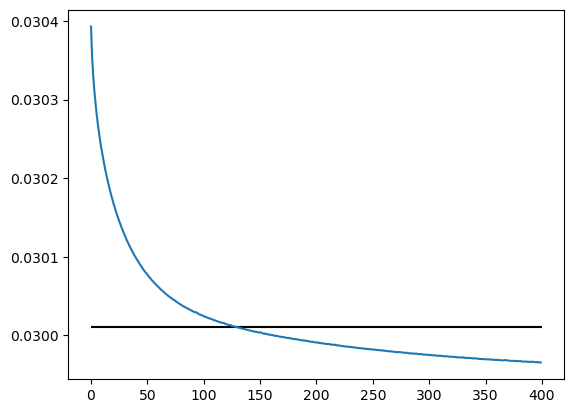

In [ ]:
plt.plot(loss_train, label="train")
plt.hlines(loss_real, 0, len(loss_train), label="real")


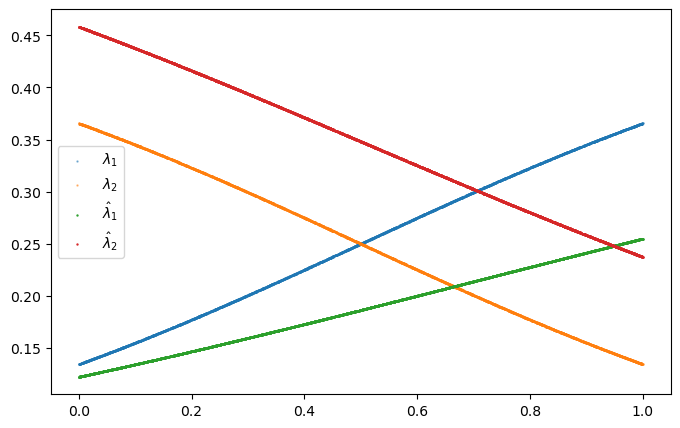

In [ ]:
weights_pred = model(torch.from_numpy(x_train).float()).detach().numpy()

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
x = x_train[:, 0]
ax.scatter(x, weights[:, 0], s=0.5, alpha=0.5, label = "$\lambda_1$")
ax.scatter(x, weights[:, 1],s=0.5,alpha=0.5, label = "$\lambda_2$")

#ax.scatter(x, weights_pred[:, 2], s=0.5, label = "$\hat{\lambda}_3$")
# make linestyle dashed
ax.scatter(x, weights_pred[:, 0], s=0.5, label = "$\hat{\lambda}_1$")
ax.scatter(x, weights_pred[:, 1], s=0.5, label = "$\hat{\lambda}_2$")

plt.legend()

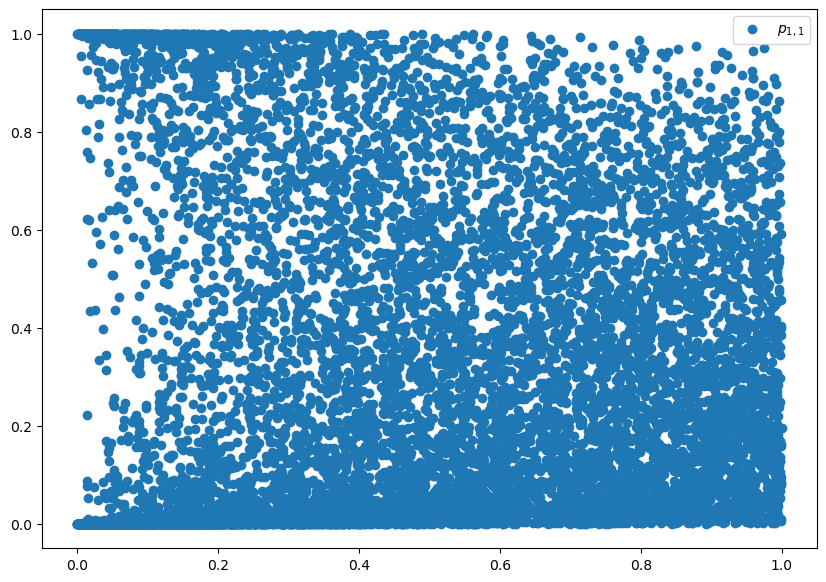

In [ ]:
# plot predictions anc convex combination
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
x = x_train[:, 0]
ax.scatter(x, p_probs[:, 0, 0], label = "$p_{1,1}$")
#ax.plot(x, p_probs[:, 0, 1],label = "$p_{1,2}$")
#ax.scatter(x, p_probs[:, 1, 0], s=0.1, label = "$p_2$")
#ax.plot(p_probs[:, 1, 0], label = "$p_2$")
#ax.plot(p_bar[:, 0], label = "$\hat{p}$")

plt.legend()

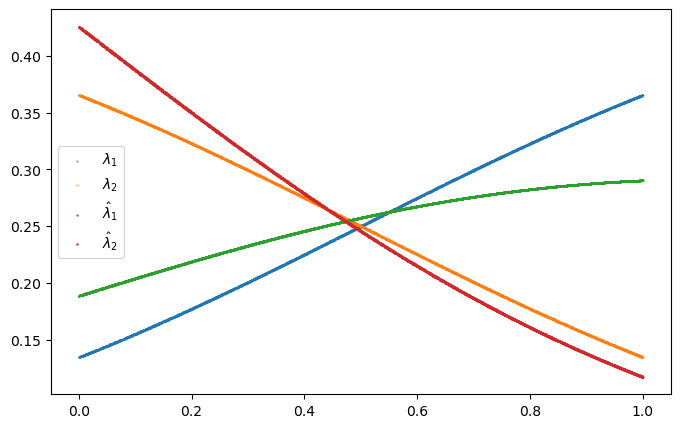

In [ ]:
weights_pred = model(torch.from_numpy(x_train).float()).detach().numpy()

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
x = x_train[:, 0]
ax.scatter(x, weights[:, 0], s=0.5, alpha=0.5, label = "$\lambda_1$")
ax.scatter(x, weights[:, 1],s=0.5,alpha=0.5, label = "$\lambda_2$")

#ax.scatter(x, weights_pred[:, 2], s=0.5, label = "$\hat{\lambda}_3$")
# make linestyle dashed
ax.scatter(x, weights_pred[:, 0], s=0.5, label = "$\hat{\lambda}_1$")
ax.scatter(x, weights_pred[:, 1], s=0.5, label = "$\hat{\lambda}_2$")

plt.legend()

In [ ]:
loss_real = loss(torch.from_numpy(p_probs).float(), torch.from_numpy(weights).float(), torch.from_numpy(y_labels))

In [ ]:
loss_real

tensor(2.8526e-08)

In [ ]:
summary(model, input_size=x_train.shape[1:])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 2]               4
           Softmax-2                    [-1, 2]               0
Total params: 4
Trainable params: 4
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


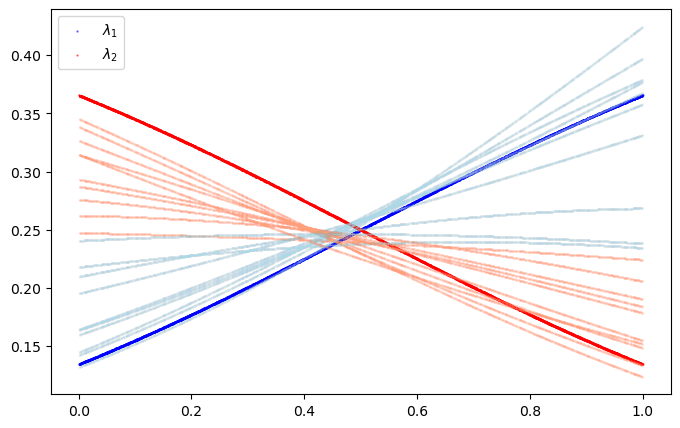

In [ ]:
weights_pred = model(torch.from_numpy(x_train).float()).detach().numpy()

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
x = x_train[:, 0]
ax.scatter(x, weights[:, 0], s=0.5, alpha=0.5, c="blue", label = "$\lambda_1$")
ax.scatter(x, weights[:, 1],s=0.5,alpha=0.5, c="red", label = "$\lambda_2$")

#ax.scatter(x, weights_pred[:, 2], s=0.5, label = "$\hat{\lambda}_3$")
# make linestyle dashed
for n in range(10):
    ax.scatter(x, weights_preds[n][:, 0], s=0.1,c="lightblue", alpha=0.1)
    ax.scatter(x, weights_preds[n][:, 1], s=0.1, alpha=0.1,c="lightsalmon")

plt.legend()

In [ ]:
# calculate skceul loss
loss_skce_real = loss_skce(torch.from_numpy(p_probs).float(), torch.from_numpy(weights).float(), torch.from_numpy(y_labels))
loss_skce_fake = loss_skce(torch.from_numpy(p_probs).float(), torch.from_numpy(weights_pred).float(), torch.from_numpy(y_labels))

In [ ]:
loss_skce_real

tensor(8.4743e-08)

In [ ]:
loss_skce_fake

tensor(4.2237e-08)

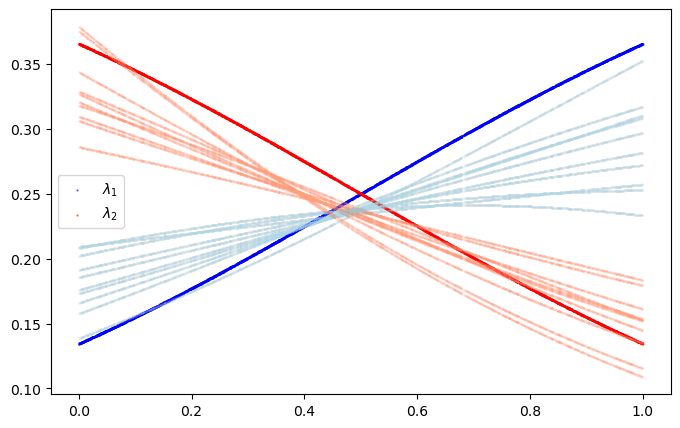

In [ ]:
weights_pred = model(torch.from_numpy(x_train).float()).detach().numpy()

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
x = x_train[:, 0]
ax.scatter(x, weights[:, 0], s=0.5, alpha=0.5, c="blue", label = "$\lambda_1$")
ax.scatter(x, weights[:, 1],s=0.5,alpha=0.5, c="red", label = "$\lambda_2$")

#ax.scatter(x, weights_pred[:, 2], s=0.5, label = "$\hat{\lambda}_3$")
# make linestyle dashed
for n in range(10):
    ax.scatter(x, weights_preds[n][:, 0], s=0.1,c="lightblue", alpha=0.1)
    ax.scatter(x, weights_preds[n][:, 1], s=0.1, alpha=0.1,c="lightsalmon")

plt.legend()

In [ ]:
# calculate skceul loss
loss_skce_real = loss_skce(torch.from_numpy(p_probs).float(), torch.from_numpy(weights).float(), torch.from_numpy(y_labels))
print(loss_skce_real)
for n in range(N_ITER):
    loss_skce_fake = loss_skce(torch.from_numpy(p_probs).float(), torch.from_numpy(weights_preds[n]).float(), torch.from_numpy(y_labels))
    print(loss_skce_fake)

tensor(1.8986e-07)
tensor(2.1650e-07)
tensor(1.9830e-07)
tensor(2.1665e-07)
tensor(2.1134e-07)
tensor(1.7260e-07)
tensor(1.9725e-07)
tensor(1.9353e-07)
tensor(1.8657e-07)
tensor(2.0718e-07)
tensor(1.7832e-07)
